In [60]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [61]:
# datasets_dir = os.path.join(os.getcwd(), 'datasets')
# files = os.listdir(datasets_dir)
# for file in files:
    # if file.endswith('.csv'):  
    #     file_path = os.path.join(datasets_dir, file)
    #     df = pd.read_csv(file_path)
    #     print(f"Data from {file}:")
    #     print(df.head()) 

In [62]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'JPM_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [63]:
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [64]:
# close_prices = df['Close'].values
# diff_close = np.diff(close_prices)  

In [65]:
diff_close_series = df['Close'].diff().dropna()

In [66]:
lag_data = []
for i in range(1, len(diff_close)-1):
    lag_data.append([
        diff_close[i-1],  # t-1
        diff_close[i],    # t
        diff_close[i+1]   # t+1
    ])


In [67]:

lag_df = pd.DataFrame(lag_data, columns=['t-1', 't', 't+1'])

# Calculate features (differences of differences)
lag_df['diff t-1'] = lag_df['t'] - lag_df['t-1']  # Feature 1: (t - t-1)
X = lag_df[['diff t-1', 't']].values  # Features: diff t-1 and t
y = lag_df['t+1'].values

In [68]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [69]:
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [70]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
model.fit(X_reshaped, y_scaled, epochs=200, batch_size=8, verbose=0)

# Iterative prediction loop
num_future_predictions = 30  # Predict 30 future values
current_t_minus_1 = diff_close[-2]  # Second-to-last difference
current_t = diff_close[-1]          # Last difference
predicted_diffs = []

In [72]:
for _ in range(num_future_predictions):
    diff_t_minus_1 = current_t - current_t_minus_1  # (t - t-1)
    features = np.array([[diff_t_minus_1, current_t]])
    
    features_scaled = scaler_X.transform(features)
    features_reshaped = features_scaled.reshape(1, 1, 2)
    
    pred_scaled = model.predict(features_reshaped, verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled)[0][0]
    predicted_diffs.append(pred)
    
    current_t_minus_1 = current_t
    current_t = pred

    last_close = close_prices[-1]
predicted_prices = [last_close + np.sum(predicted_diffs[:i+1]) 
                    for i in range(len(predicted_diffs))]


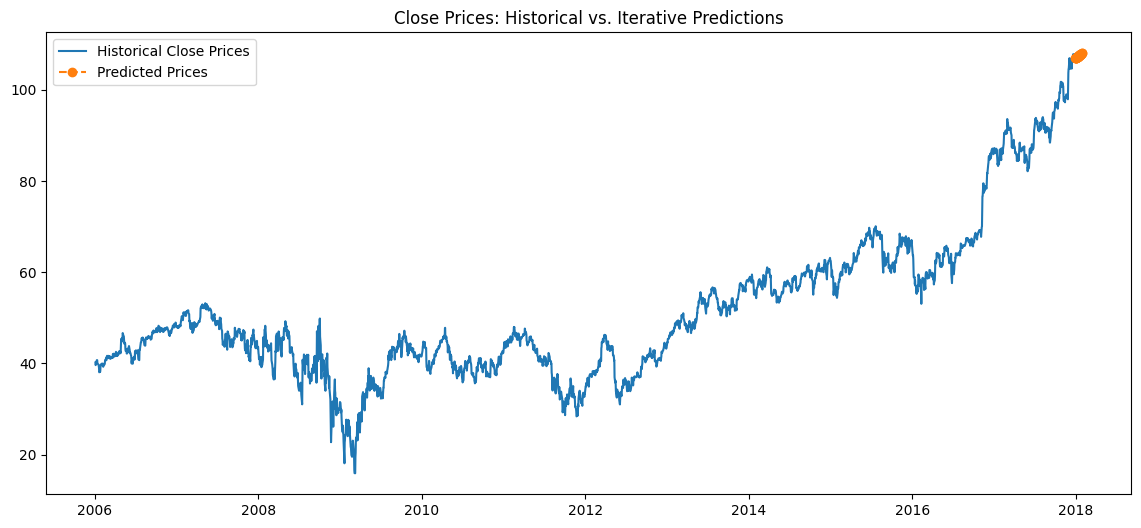

In [73]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, close_prices, label='Historical Close Prices')
future_dates = pd.date_range(start=df.index[-1], periods=num_future_predictions+1, inclusive='right')
plt.plot(future_dates, predicted_prices, label='Predicted Prices', marker='o', linestyle='--')
plt.title('Close Prices: Historical vs. Iterative Predictions')
plt.legend()
plt.show()